# HW 3. Сканнер судоку

В этом задании, вам предлагается решить задачу распознавания чисел на решетке судоку. Для этого вам нужно реализовать следующие функции:

1. Конвертация в нужное цветовое пространство
2. Поиск решетки на изображении через контуры
3. Перспектива решетки судоку для распознавания
4. Выделение ячеек с числами
5. Обучение нейронной сети на MNIST
6. Распознавание цифр в судоку с помощью сети

In [1]:
import cv2
from PIL import Image
from skimage.segmentation import clear_border

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import requests

In [2]:
def READ_RGB(path):
    if path.startswith("http://") or path.startswith("https://"):
        response = requests.get(path)
        response.raise_for_status()
        image_array = np.frombuffer(response.content, np.uint8)
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    else:
        image = cv2.imread(path)

    if image is None:
        raise ValueError(f"Не удалось загрузить изображение из {path}")

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def SHOW_IMAGE(image):
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()

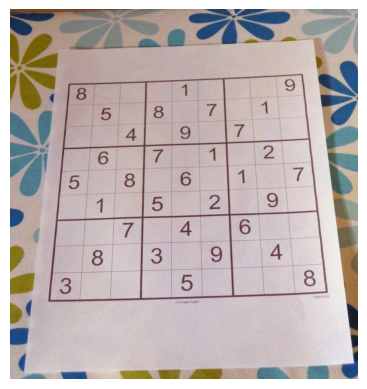

In [3]:
# Загружаем изображение
img_rgb = READ_RGB(
    "https://drive.google.com/uc?export=download&id=1vnPUdJiI78k5E-S_n7g7DE62OjASIn1J"
)
SHOW_IMAGE(img_rgb)

## Бинаризация

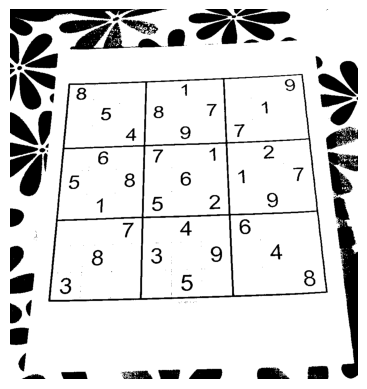

In [4]:
# Перевод из RBG в Grayscale и накладываем фильтр
# Write your code here
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
# Бинаризация
# Write your code here
img_bin = (img_gray > 130).astype(np.uint8) * 255
SHOW_IMAGE(img_bin)

## Поиск контуров

На этом этапе мы хотим найти решетку с судоку. По нашему предположению, это наибольший по площади четырехугольник

In [5]:
# Функция для уменьшения ребер в контуре, как на предыдущей лабе
def Approximating(contour, epsilon=0.1):
    # Периметр контура
    length = cv2.arcLength(contour, True)
    # Аппроксимирует контурную форму к форме с меньшим количеством вершин
    # в зависимости от указанной точности. Это реализация алгоритма Рамера — Дугласа — Пекера.
    approx = cv2.approxPolyDP(contour, epsilon * length, True)
    return approx

In [6]:
# Найдите контуры с помощью opencv
# Write your code here
contours = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

In [7]:
img_contours = img_rgb.copy()
# Write your code here
# Отсортируйте контуры по площади
contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
# Аппроксимируйте контуры, чтобы с бОльшей вероятностью получить четырехугольник
approx_contours = [Approximating(contour) for contour in contours_sorted]
# Выберите только те контуры, которые являются четырехугольникам
approx_rect = [contour for contour in approx_contours if len(contour) == 4]
approx_rect = sorted(approx_rect, key=cv2.contourArea, reverse=True)

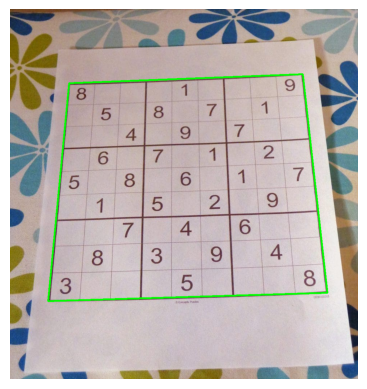

In [8]:
cv2.drawContours(img_contours, approx_rect, 0, (0, 255, 0), 3)
SHOW_IMAGE(img_contours)

## WarpTransform

На этом этапе, мы сделаем перспективу решетки на новое изображение. Размерность нового изображения мы можем задать сами, поэтому упростим себе жизнь: пусть размер каждой ячейки будет 28x28, чтобы без лишних трансформаций отправлять их в нейронную сеть. Количество ячеек в судоку - 9 на 9. Таким образом, длина и ширина изображения будут 9x28 (мы не учитываем толщину линий между ячейчками)

In [9]:
img_contours = img_rgb.copy()

output_size = 28 * 9

# Write your code here
# Составьте матрицу для warpPerspective и выполните трансформацию
M = cv2.getPerspectiveTransform(
    approx_rect[0].astype(np.float32),
    np.array(
        [
            [output_size, 0],
            [output_size, output_size],
            [0, output_size],
            [0, 0],
        ],
        dtype=np.float32,
    ),
)
warped = cv2.warpPerspective(img_contours, M, (output_size, output_size))

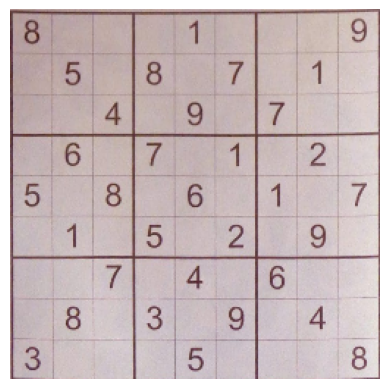

In [10]:
SHOW_IMAGE(warped)

## Разделение

Дальше ячейки будем делить не по линиям на изображении, а по предварительным расчетам, что каждая цифра находится в ячейке размером 28 на 28, а размерность решетки судоку 9 на 9

В ячейки может попасть мусор в виде границ между ячейками. От него можно избавиться с помощью великолепной функции `clear_border`, которая удаляет все ненужные части изображения по краям.

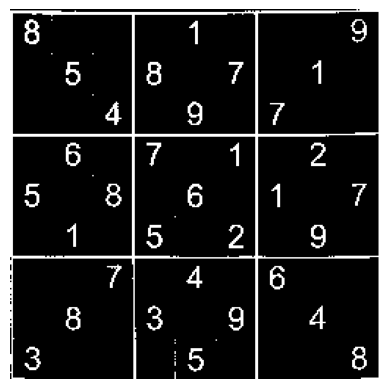

In [11]:
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
_, warped_binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
SHOW_IMAGE(warped_binary)

In [12]:
nCols = 9
nRows = 9
size = 28

grid = []
for i in range(0, nRows):
    grid.append([])
    for j in range(0, nCols):
      # Write your code here
      # Добавьте в grid соответствующий кусок изображения
      subImg = warped_binary[i * size : (i + 1) * size, j * size : (j + 1) * size]
      grid[i].append(clear_border(subImg))

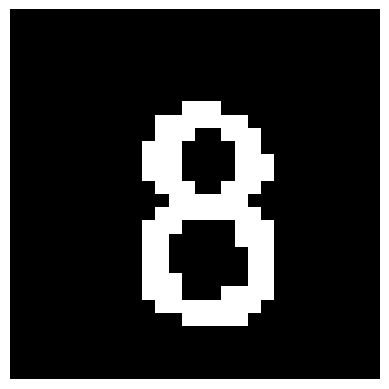

In [13]:
SHOW_IMAGE(grid[0][0])

## Обучение сети для распознавания

Обучим простую сеть для распознавания цифр на MNIST. Поскольку вы уже делали похожие задания, здесь ничего дописывать не обязательно, код вернет приличную нейронку `model`, хотя вы можете попробовать по-экспериментировать с ней

In [14]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 512
learning_rate = 0.001
num_epochs = 15

# Data augmentation and normalization for training
train_transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=4,
        ),
        
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=test_transform
)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Initialize model, loss function and optimizer
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} "
                f"({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}"
            )


def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = correct / len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss/len(test_loader):.4f}, "
        f"Accuracy: {correct}/{len(test_loader.dataset)} "
        f"({100.*accuracy:.0f}%)\n"
    )


# Train the model
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

print("Training completed!")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306382
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.385478

Test set: Average loss: 0.1884, Accuracy: 9431/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.357325
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.164666

Test set: Average loss: 0.1024, Accuracy: 9659/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.280462
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.186140

Test set: Average loss: 0.0833, Accuracy: 9729/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.206231
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.113910

Test set: Average loss: 0.0732, Accuracy: 9757/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.122593
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.125801

Test set: Average loss: 0.0620, Accuracy: 9799/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.069902
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.102790

Test set: Average loss: 0.0614, Accuracy: 9801/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.093943
Train Epoch: 7 [512

## Итоговое распознавание

Теперь мы можем проверить, как работает нейронка на кусках изображения из нашего судоку. Поскольку у модели нет класса "пустое изображение", которые встречается в нашем случае, придется отфильтровывать такие ячейки. Мы сделаем это из предположение, что если в ячейке нет контуров, то она пустая.

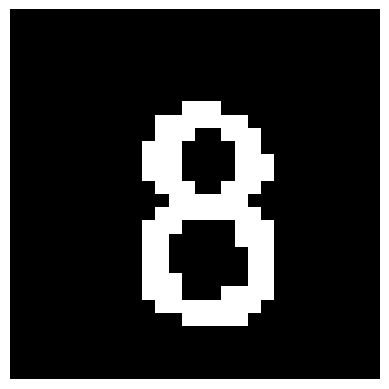

Some number in cell 0 0. Predicted: 8
Empty cell 0 1
Empty cell 0 2
Empty cell 0 3


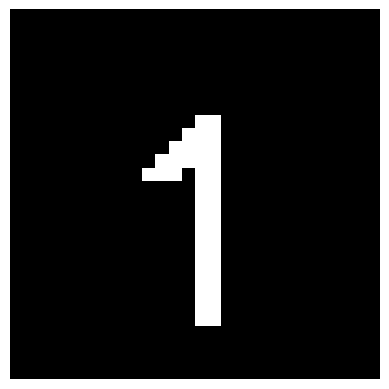

Some number in cell 0 4. Predicted: 1
Empty cell 0 5
Empty cell 0 6
Empty cell 0 7


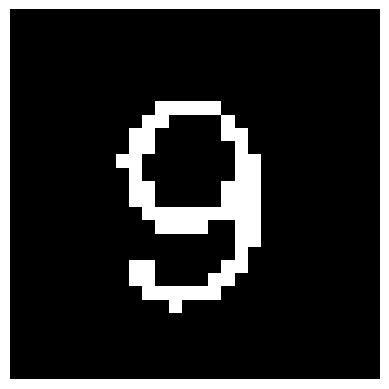

Some number in cell 0 8. Predicted: 9
Empty cell 1 0


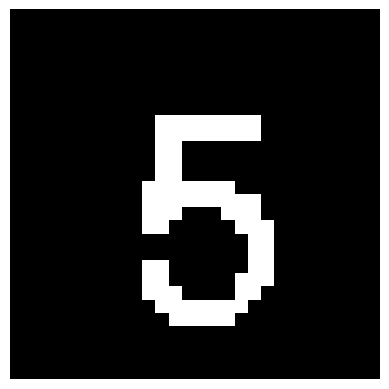

Some number in cell 1 1. Predicted: 5
Empty cell 1 2


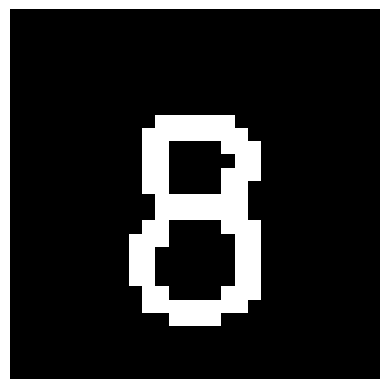

Some number in cell 1 3. Predicted: 8
Empty cell 1 4


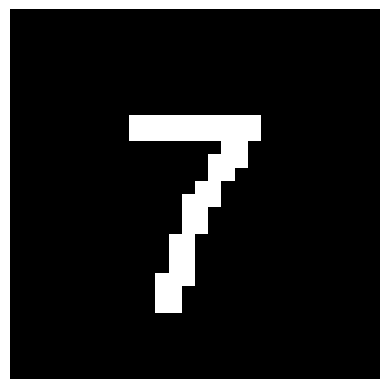

Some number in cell 1 5. Predicted: 7
Empty cell 1 6


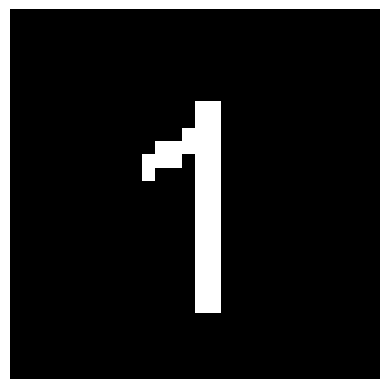

Some number in cell 1 7. Predicted: 1
Empty cell 1 8
Empty cell 2 0
Empty cell 2 1


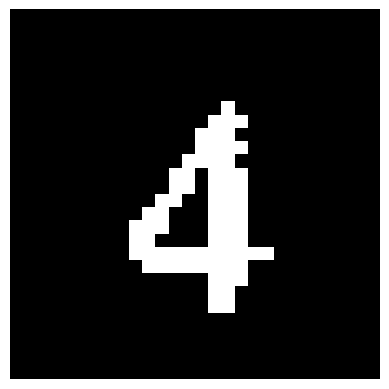

Some number in cell 2 2. Predicted: 4
Empty cell 2 3


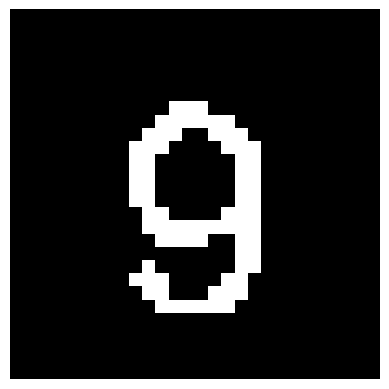

Some number in cell 2 4. Predicted: 9
Empty cell 2 5


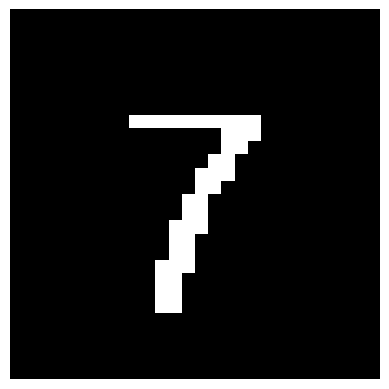

Some number in cell 2 6. Predicted: 7
Empty cell 2 7
Empty cell 2 8
Empty cell 3 0


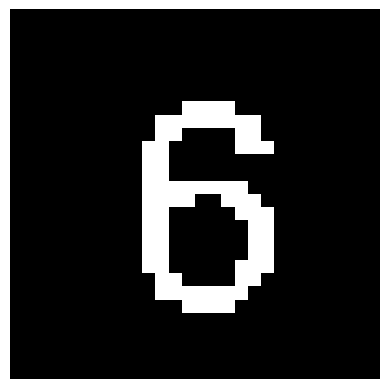

Some number in cell 3 1. Predicted: 5
Empty cell 3 2


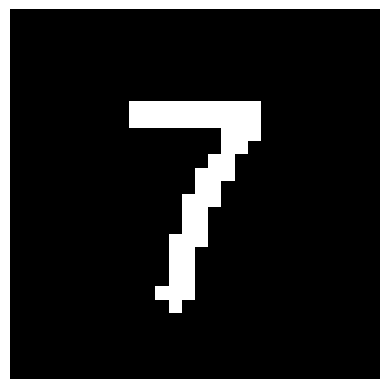

Some number in cell 3 3. Predicted: 7
Empty cell 3 4


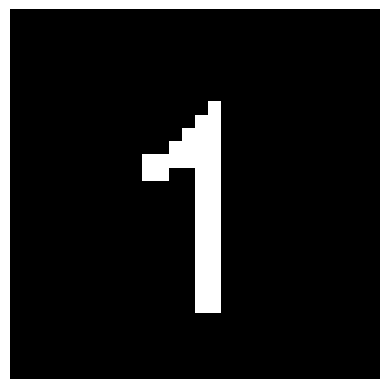

Some number in cell 3 5. Predicted: 1
Empty cell 3 6


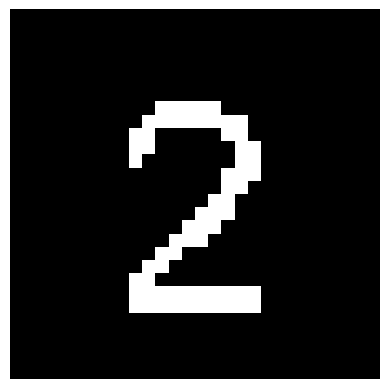

Some number in cell 3 7. Predicted: 2
Empty cell 3 8


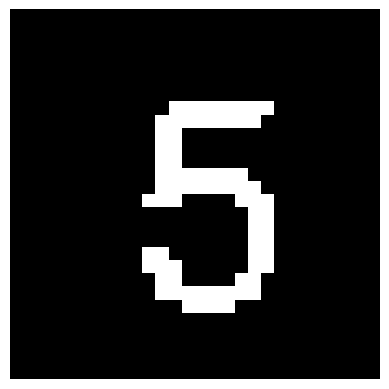

Some number in cell 4 0. Predicted: 5
Empty cell 4 1


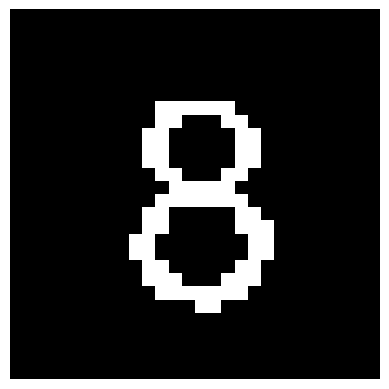

Some number in cell 4 2. Predicted: 8
Empty cell 4 3


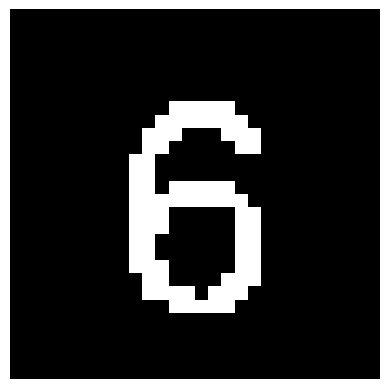

Some number in cell 4 4. Predicted: 6
Empty cell 4 5


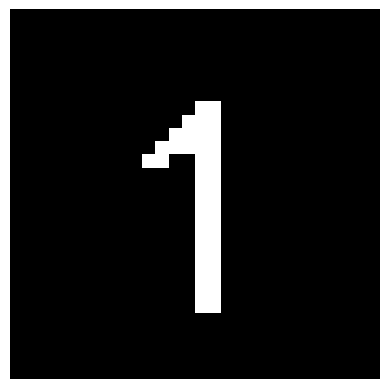

Some number in cell 4 6. Predicted: 1
Empty cell 4 7


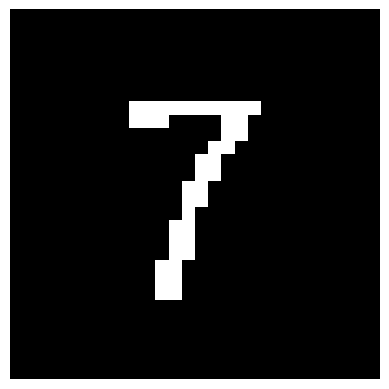

Some number in cell 4 8. Predicted: 7
Empty cell 5 0


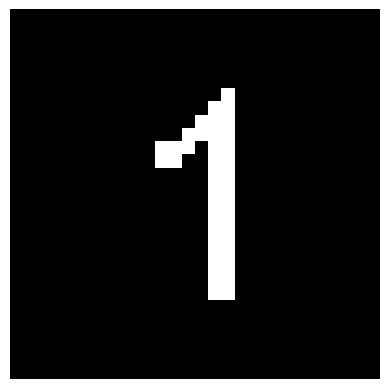

Some number in cell 5 1. Predicted: 1
Empty cell 5 2


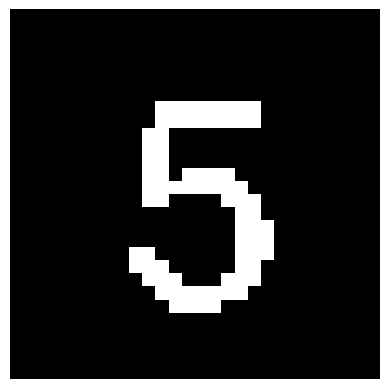

Some number in cell 5 3. Predicted: 5
Empty cell 5 4


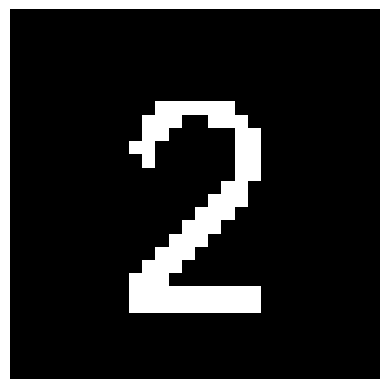

Some number in cell 5 5. Predicted: 2
Empty cell 5 6


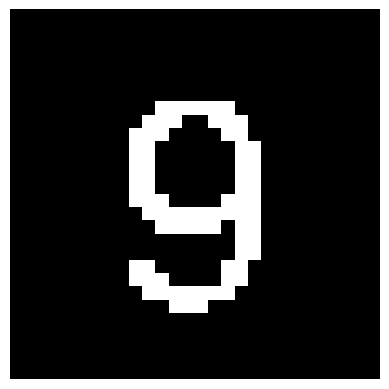

Some number in cell 5 7. Predicted: 9
Empty cell 5 8
Empty cell 6 0
Empty cell 6 1


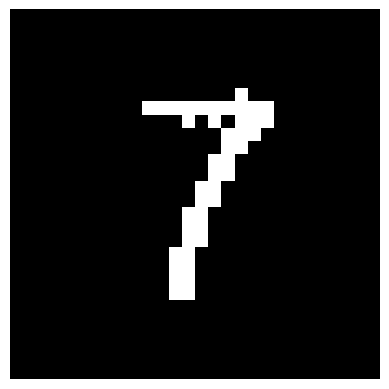

Some number in cell 6 2. Predicted: 7
Empty cell 6 3


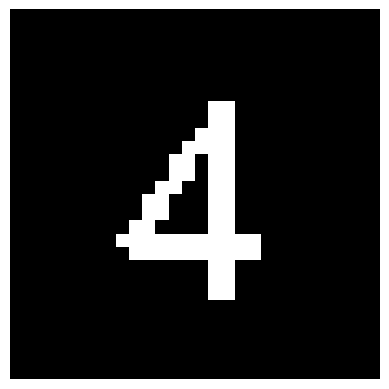

Some number in cell 6 4. Predicted: 4
Empty cell 6 5


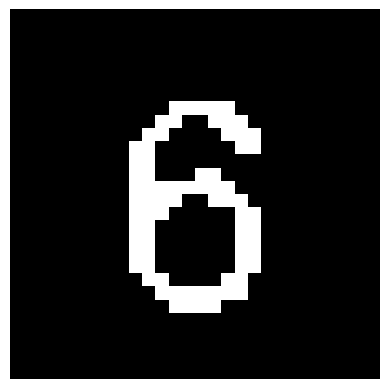

Some number in cell 6 6. Predicted: 6
Empty cell 6 7
Empty cell 6 8
Empty cell 7 0


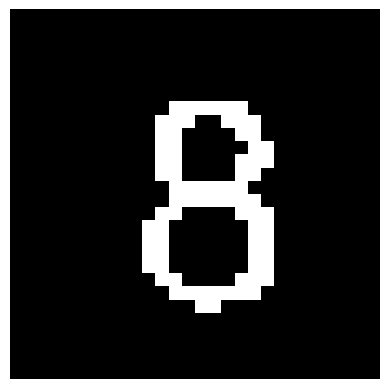

Some number in cell 7 1. Predicted: 8
Empty cell 7 2


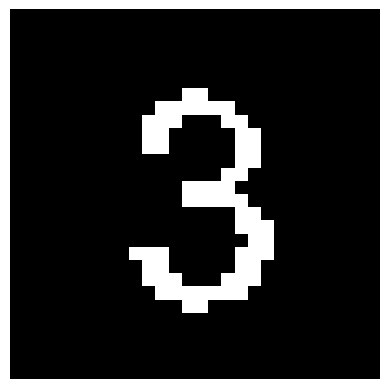

Some number in cell 7 3. Predicted: 3
Empty cell 7 4


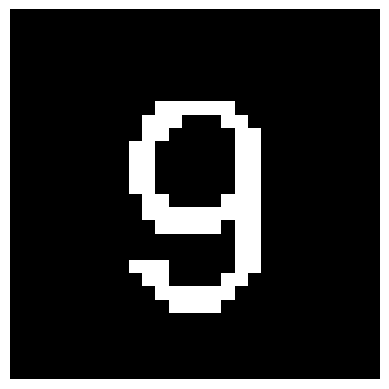

Some number in cell 7 5. Predicted: 8
Empty cell 7 6


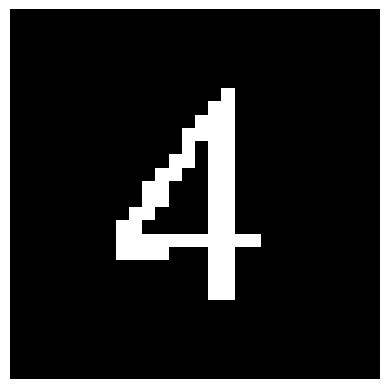

Some number in cell 7 7. Predicted: 4
Empty cell 7 8


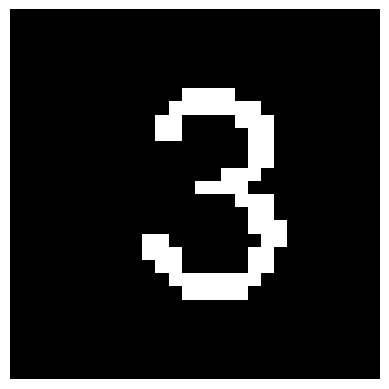

Some number in cell 8 0. Predicted: 2
Empty cell 8 1
Empty cell 8 2
Empty cell 8 3


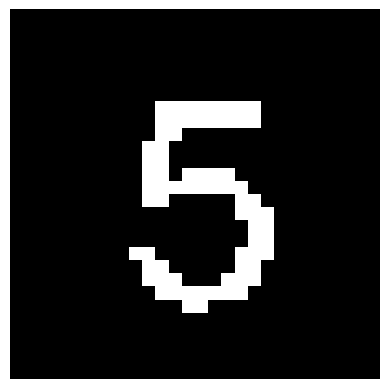

Some number in cell 8 4. Predicted: 5
Empty cell 8 5
Empty cell 8 6
Empty cell 8 7


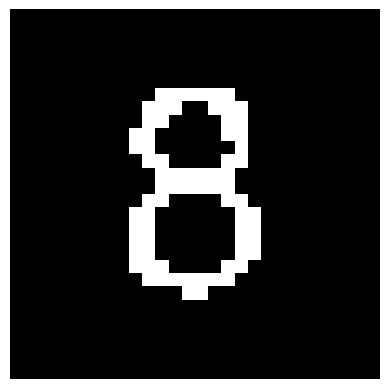

Some number in cell 8 8. Predicted: 8


In [15]:
for i in range(0, nRows):
    for j in range(0, nCols):
        bb = grid[i][j]
        # Write your code here
        # Если в bb нет конкуров, выведите об этом сообщение. Иначе, отправьте bb в нейронку
        # и выведите предсказание. Не забудьте, что bb имеет размерность (28,28),
        # а нейронка работает с тензорами размерности (batch_size,1,28,28).
        if not cv2.findContours(bb, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]:
            print(f"Empty cell {i} {j}")
        else:
            SHOW_IMAGE(bb)
            bb = Image.fromarray(bb).convert("L")
            bb = test_transform(bb).to(device)
            output = model(bb)
            _, predicted = torch.max(output.data, 1)
            print(f"Some number in cell {i} {j}. Predicted: {predicted.item()}")
            